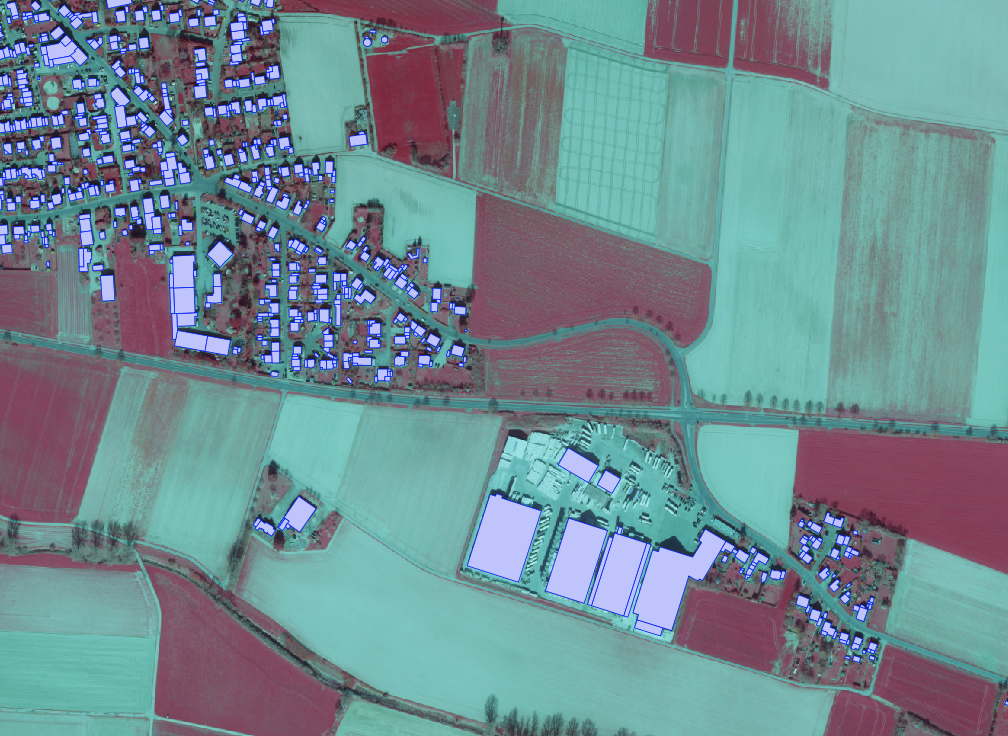

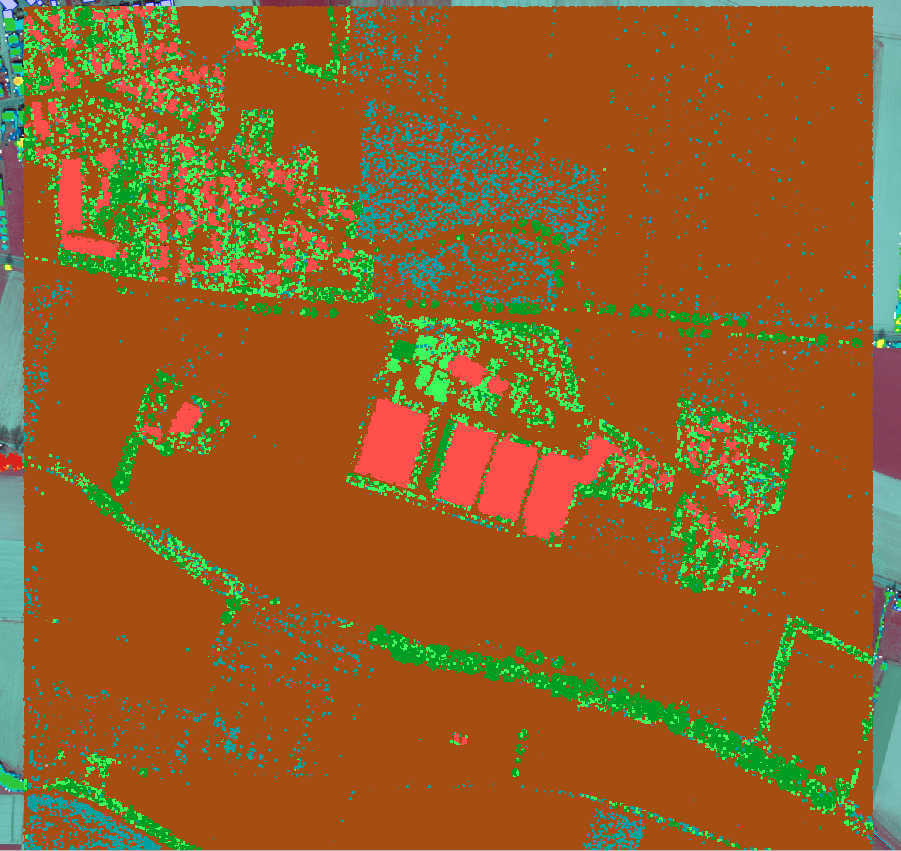

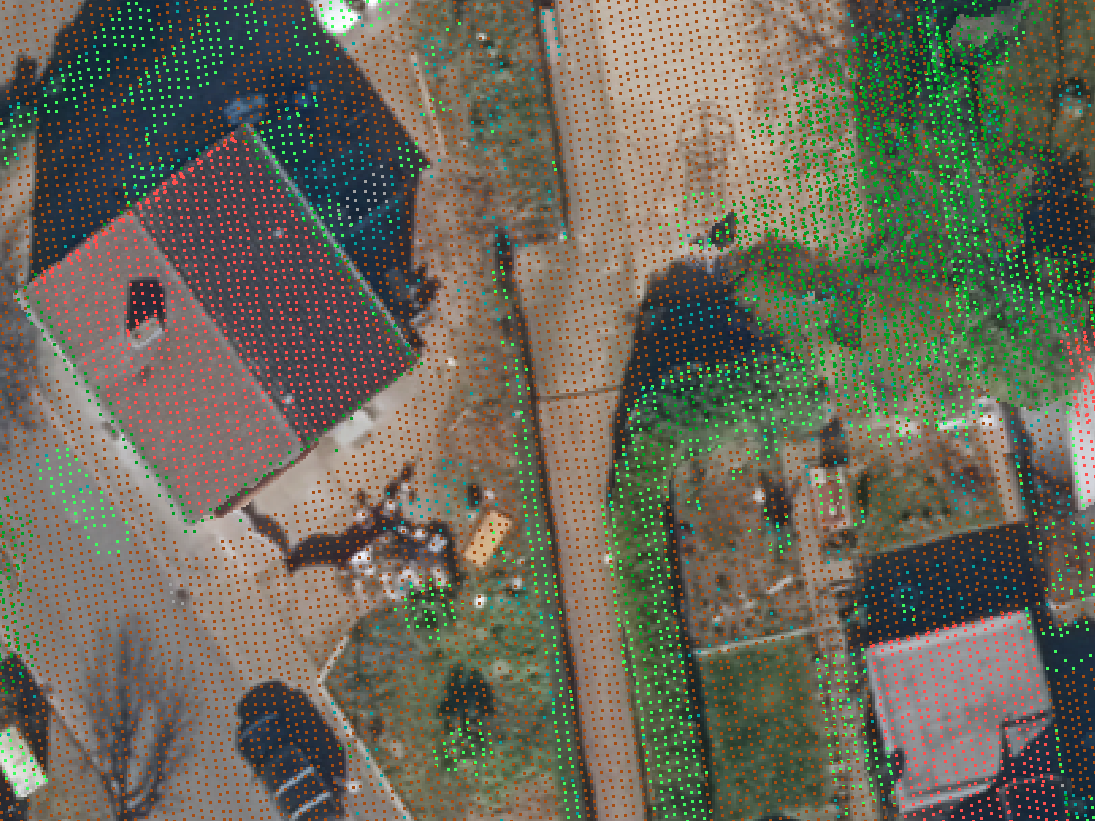

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
51.389996
Original tiff:


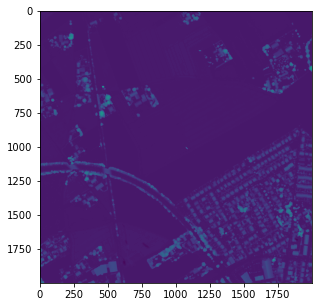

Theshold= 30
Geglättet:


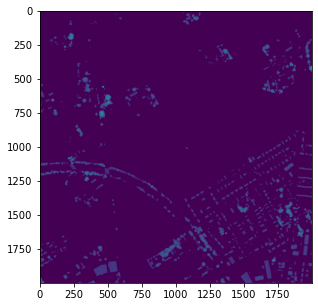

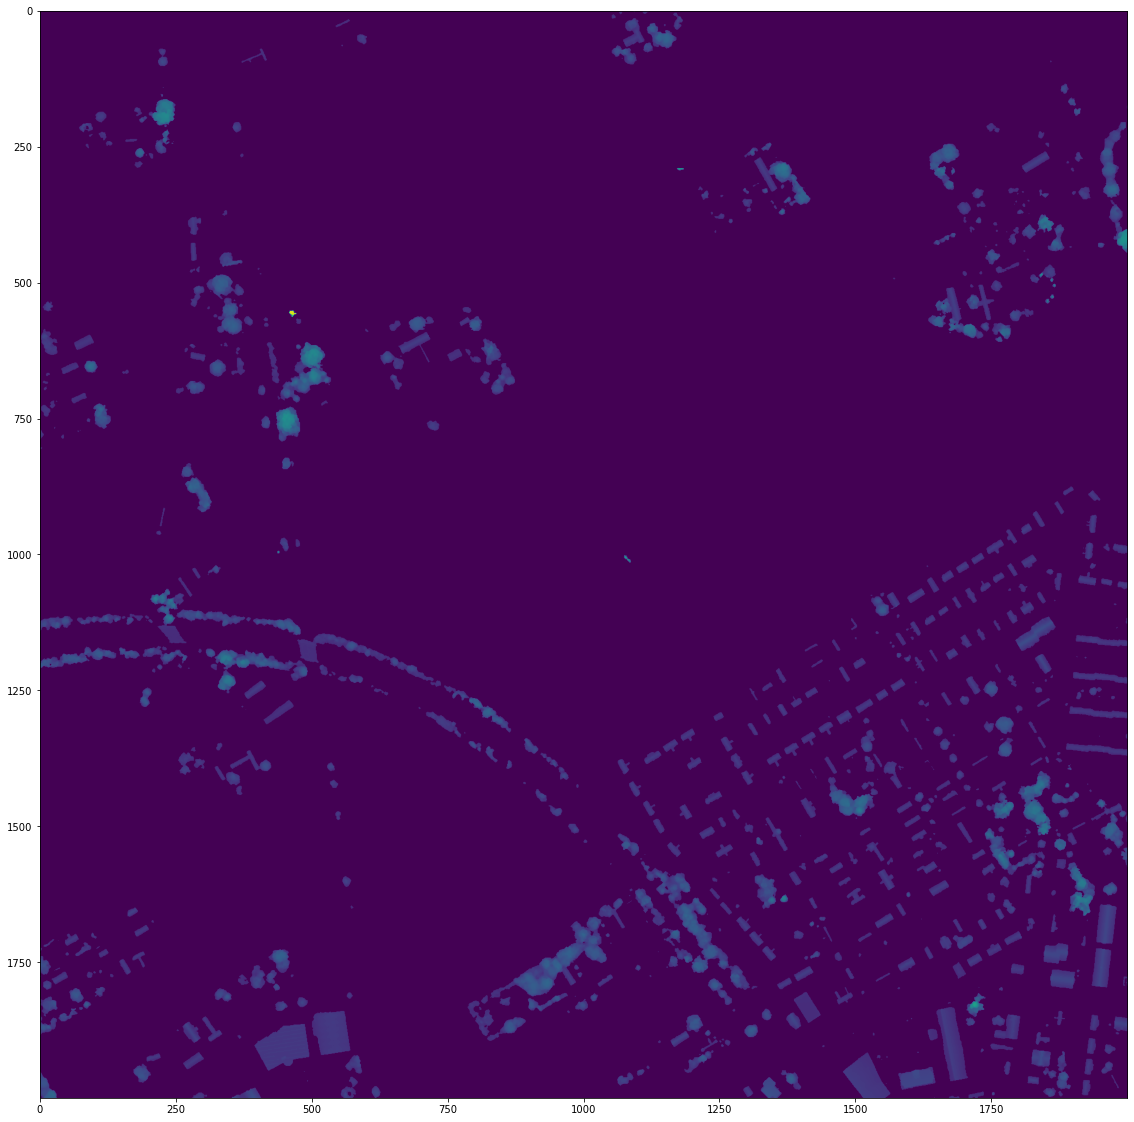

In [1]:
from scipy import ndimage as ndi
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage import median_filter
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage import img_as_float
from PIL import Image
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import coord_f
import numpy
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline  
from tqdm import tqdm
import visualize
#ganz schlecht klassifiziet:3dm_32_330_5726_1_nw.las

las_files=["3dm_32_335_5728_1_nw_classified.laz", "3dm_32_331_5722_1_nw.las","3dm_32_338_5725_1_nw.las", "3dm_32_337_5727_1_nw.las", "3dm_32_337_5726_1_nw.las","3dm_32_337_5725_1_nw.las"]
folder = "demo"
las_file = folder+ "/" + las_files[0]

#setze größe der geplotteten bilder:
plt.rcParams['figure.figsize'] = [5, 5]

#lade bild als numpy.array
bdom_file = "ndom50_32335_5728_1_nw_2018.tif"
im = numpy.array(Image.open(bdom_file))
#scaliere in pixel-werte größer 0
m = - numpy.min(im)
#im = im + m

#scaliere in range(0,255) und als integer-array:
m = numpy.max(im)
print(m)
im = ((im/m) *255).astype(numpy.int32)

print("Original tiff:")
plt.imshow(im)
plt.show()

#setze alle pixelwerte < thresshold = 0, um den boden zu glätten
#sonst werden bei jeder kleinen bodenwelle lokale maxima gefunden
threshhold =30 #(numpy.max(im) + numpy.min(im)) * 0.03
print("Theshold=", threshhold)
im = numpy.where(im > threshhold, im, 0) # 0.3,
print("Geglättet:")

plt.imshow(im)
plt.show()
##gaussischer filter (falsch!):
#print("Weichzeichnen:")
#im = gaussian_filter(im, sigma=3)
#median filter
im = median_filter(im, size=3)


#setze größe der geplotteten bilder:
plt.rcParams['figure.figsize'] = [20, 20]
plt.imshow(im)
plt.show()


#43 Bäume laut kataster


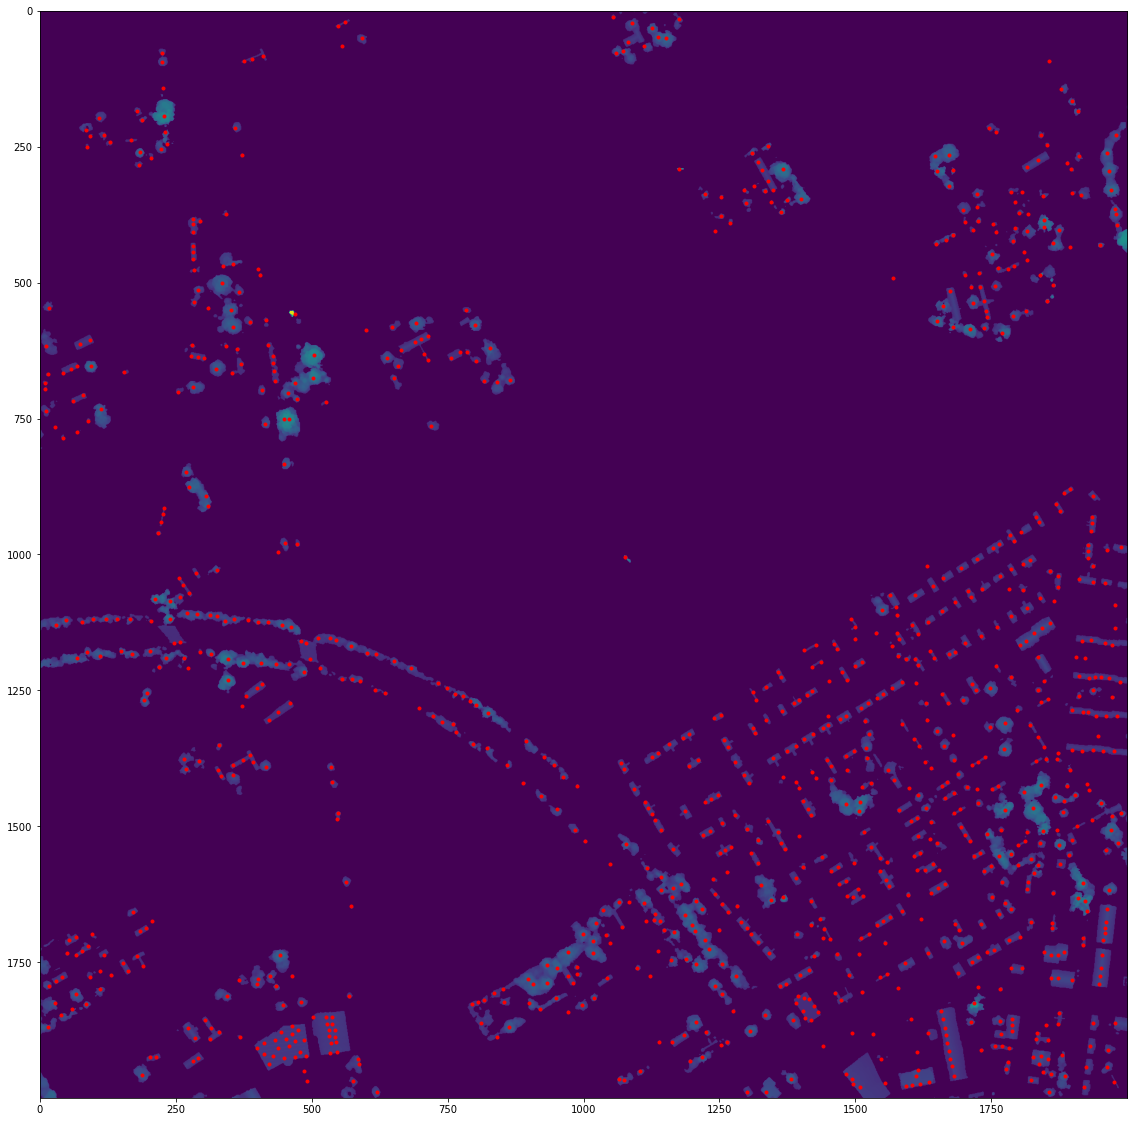

Anzahl Maxima: 1059


In [2]:
#wenn hier die maxima im einfarbigen bereich auftauchen, ist der threshold oben zu niedrig
#hier kann über den min-distance-wert skaliert werden:

min_distance = 10 # 8<= x  <= 15

#image_max = ndi.maximum_filter(im, size=1)   #, mode='constant'
# Comparison between image_max and im to find the coordinates of local maxima
coordinates = []
# https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.peak_local_max :
coordinates = peak_local_max(im, min_distance=min_distance)


plt.imshow(im)
plt.plot(coordinates[:, 1], coordinates[:, 0], 'r.')
plt.show()
print("Anzahl Maxima:", len(coordinates))

In [3]:
import laspy

las = laspy.read(las_file)

visualize.plot_las_3d(las, color='classification')


[[1.         0.07843137 0.57647059]
 [1.         0.07843137 0.57647059]
 [1.         0.07843137 0.57647059]
 ...
 [0.95686275 0.64313725 0.37647059]
 [0.95686275 0.64313725 0.37647059]
 [0.95686275 0.64313725 0.37647059]]


In [4]:
las_points_x = numpy.array(las.points['x']) 
las_points_y = numpy.array(las.points['y'])
x_max, x_min, y_max, y_min = las_points_x.max(),  las_points_x.min(), las_points_y.max(),  las_points_y.min()
x_range = x_max - x_min
y_range = y_max - y_min
print(x_max, x_min,x_range, y_max, y_min, y_range)

336000.01 334999.98 1000.0300000000279 5729000.01 5727999.98 1000.0299999993294


In [5]:
import pandas

#koordinaten vom geotiff  bestimmen - > utm koodinate jedes pixels ableiten  - > die coordiates-liste umrechnen 
#- > nächste punkte bestimmen
#load metadata csv
meta_data = pandas.read_csv("metadata/ndom_nw.csv", sep=";")
kachelname = bdom_file.split("/")[-1].split(".")[0]
row = meta_data.loc[meta_data['Kachelname'] == kachelname]

#cpnvert coordinates to ut coords_
x_pixels, y_pixels = im.shape[1],im.shape[0]
step = row['Aufloesung_cm'].values[0]/100  #0.5m per pixel!
utm_coordinates = numpy.zeros((len(coordinates), 2))
for i in range(len(utm_coordinates)):
    utm_coordinates[i][0] = coordinates[i][1] * step + x_min
    utm_coordinates[i][1] = y_max - coordinates[i][0] * step


In [6]:
#check utm_coordinates:
import folium
import coord_f
tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',



lat,long = coord_f.utm_to_lat_long(x_max, y_max)
lat_min,long_min = coord_f.utm_to_lat_long(x_min, y_min)

f_map = folium.Map(location=[lat, long], zoom_start=14)
#add las area:
folium.Marker(location=[lat, long],icon=folium.Icon(color="red")).add_to( f_map )
folium.Marker(location=[lat_min, long_min],icon=folium.Icon(color="red")).add_to( f_map )
folium.Marker(location=[lat, long_min],icon=folium.Icon(color="red")).add_to( f_map )
folium.Marker(location=[lat_min, long],icon=folium.Icon(color="red")).add_to( f_map )

latlong_coordinates = list(map(coord_f.utm_to_lat_long, list(zip(*utm_coordinates))[0],  list(zip(*utm_coordinates))[1]))
#add trees:
for lat, long in latlong_coordinates:
    folium.Marker(location=[lat, long],icon=folium.Icon(color="green")).add_to( f_map )

f_map

In [7]:
from sklearn.cluster import DBSCAN
length = len(las.points['x'])

points_to_cluster = numpy.array([[las.points['x'][i], las.points['y'][i], las.points['z'][i]] for i in tqdm(range(length)) if (las.points['classification'][i] == 5)]) 
indices_of_cluster_points = numpy.array([i for i in tqdm(range(length)) if (las.points['classification'][i] == 5)]) 
cluster = DBSCAN(eps=1, min_samples=10).fit(points_to_cluster)  # parameters according to https://www.degruyter.com/document/doi/10.1515/geo-2020-0266/html?lang=de
labels = cluster.labels_
for i, l in tqdm(zip(indices_of_cluster_points, labels)):
    if l == -1:
        las.points['classification'][i] = 1 



100%|██████████| 7401340/7401340 [01:34<00:00, 78686.16it/s]
1351177it [00:03, 440980.87it/s]


In [8]:
from scipy.spatial import distance
#find list of nearest points in las:    
centroids_in_las = numpy.zeros((len(utm_coordinates), 3))
z =numpy.max(numpy.array(las.points['z']))

las_points = numpy.array((las.points['x'], las.points['y'],las.points['z'])).transpose()  #hier noch nach classification filtern!
print(las_points)
for i in tqdm(range(len(utm_coordinates) -1, -1, -1 )):
        coord = [utm_coordinates[i][0], utm_coordinates[i][1], z]
        closest_index = int(distance.cdist([coord], las_points).argmin())
        c = las.points['classification'][closest_index]
        if c in [5]:
            centroids_in_las[i] = las.points['x'][closest_index], las.points['y'][closest_index], las.points['z'][closest_index]
        else:
            centroids_in_las = numpy.delete(centroids_in_las, i,  axis=0)

print(len(centroids_in_las))

[[3.35019760e+05 5.72800128e+06 2.58400000e+01]
 [3.35019680e+05 5.72800050e+06 2.58800000e+01]
 [3.35019630e+05 5.72800012e+06 2.59200000e+01]
 ...
 [3.35981070e+05 5.72899980e+06 2.24600000e+01]
 [3.35980940e+05 5.72899897e+06 2.24500000e+01]
 [3.35980280e+05 5.72899905e+06 2.24900000e+01]]


100%|██████████| 1059/1059 [01:10<00:00, 15.10it/s]

535


In [9]:
lat,long = coord_f.utm_to_lat_long(x_max, y_max)
lat_min,long_min = coord_f.utm_to_lat_long(x_min, y_min)

f_map = folium.Map(location=[lat, long], zoom_start=14)
#add las area:
folium.Marker(location=[lat, long],icon=folium.Icon(color="red")).add_to( f_map )
folium.Marker(location=[lat_min, long_min],icon=folium.Icon(color="red")).add_to( f_map )
folium.Marker(location=[lat, long_min],icon=folium.Icon(color="red")).add_to( f_map )
folium.Marker(location=[lat_min, long],icon=folium.Icon(color="red")).add_to( f_map )

latlong_coordinates = list(map(coord_f.utm_to_lat_long, list(zip(*centroids_in_las))[0],  list(zip(*centroids_in_las))[1]))
#add trees:
for lat, long in latlong_coordinates:
    folium.Marker(location=[lat, long],icon=folium.Icon(color="green")).add_to( f_map )

f_map

0 Nie klassifiziert
1 Nicht zugewiesen
2 Oberfläche
3 Niedrige Vegetation
4 Mittelhohe Vegetation
5 Hohe Vegetation
6 Gebäude
7 Tiefpunkt
8 Reserviert
9 Wasser
10 Schienen
11 Straßenbelag
12 Reserviert
13 Schutzdraht (Schild)
14 Drahtleiter (Phase)
15 Strommast
16 Leitungsverbinder (Isolator)
17 Brückenfahrbahn
18 Hohes Rauschen

In [10]:
import clustering
used_classifications = [5]
points_to_cluster = numpy.array([[las.points['x'][i], las.points['y'][i], las.points['z'][i]] for i in tqdm(range(len(las.points['x']))) if (las.points['classification'][i] in used_classifications)]) 
#geht das mit fiter vielleicht schneller? 1:30 ist viel zu langsam..

ModuleNotFoundError: No module named 'clustering'

In [ ]:
#print(centroids_in_las)
print(points_to_cluster)

kmeans= clustering.k_means_no_dbscan(centroids_in_las, points_to_cluster, 1)

In [ ]:
labels = kmeans.labels_
cluster_dict = {}
for i in range(max(labels) +1):
    cluster_dict[i] = []
for i, p in tqdm(zip(labels, points_to_cluster)):
    cluster_dict[i] =  cluster_dict[i] + [p]


In [ ]:
# plot one cluster:
#print(cluster_dict[0])
for i in [0,1,2,3,4,5,6,7,8, 8, 9,10,11,12,13]:
    points = cluster_dict[i]
    #MultiPoint(points)
    x = [point[0] for point in points]
    y = [point[1] for point in points]
    z = [point[2] for point in points]

    #plt.scatter(xs, ys)
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z)
    plt.show()

In [ ]:
"""connected_cluster_dict = {}
for val in cluster_dict.values():
    small_clusters = DBSCAN(eps=3, min_samples=1).fit(val)  # parameters according to https://www.degruyter.com/document/doi/10.1515/geo-2020-0266/html?lang=de
    labels = small_clusters.labels_

    
    tree = numpy.array(val).transpose((1, 0))
    x = tree[0]
    y = tree[1] 
    points_2d = numpy.array([x,y]).transpose()

    if len(points_2d) > 50:
        hull = ConvexHull(points_2d)
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 3))

        for ax in (ax1, ax2):
            ax.plot(points_2d[:, 0], points_2d[:, 1], '.')
            if ax == ax1:
                ax.set_title('Given points')
            else:
                ax.set_title('Convex hull')
                for simplex in hull.simplices:
                    ax.plot(points_2d[simplex, 0], points_2d[simplex, 1], 'c')
                ax.plot(points_2d[hull.vertices, 0], points_2d[hull.vertices, 1], 'o', mec='r', color='none', lw=1, markersize=10)
        plt.show()
        print((numpy.array(labels).max() +1))
""" 

In [ ]:
#x/y-convex hull
hull_dict = {}
for i in range(max(labels) +1):
    tree = numpy.array(cluster_dict[i]).transpose((1, 0))
    x = tree[0]
    y = tree[1]    
    points_2d = numpy.array([x,y]).transpose()
    if len(points_2d) > 50:
        hull = ConvexHull(points_2d)
        """
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 3))

        for ax in (ax1, ax2):
            ax.plot(points_2d[:, 0], points_2d[:, 1], '.', color='k')
            if ax == ax1:
                ax.set_title('Given points')
            else:
                ax.set_title('Convex hull')
                for simplex in hull.simplices:
                    ax.plot(points_2d[simplex, 0], points_2d[simplex, 1], 'c')
                ax.plot(points_2d[hull.vertices, 0], points_2d[hull.vertices, 1], 'o', mec='r', color='none', lw=1, markersize=10)
        plt.show()
        """
        print(points_2d[hull.vertices])
        hull_dict[i] = Polygon(points_2d[hull.vertices])

    

In [ ]:
#db lockup baumkataster

import db_settings
db =db_settings.db(autocommit=False)

db_file_name = las_file.split('.')[0].split('/')[-1] + '.laz'
db_file_name = db_file_name[8:]
print(db_file_name)
req = """SELECT ID FROM LIDAR.LIDAR_FILES WHERE FILE_NAME = \'"""+db_file_name+"""\'"""
lidar_file_number = db.export_to_pandas(req)

trees =db.export_to_pandas("""SELECT * FROM BAEUME.BAEUME WHERE STADT=""" + str(3)) #+"""and LIDAR_FILE="""+str(lidar_file_number['ID'].values[0])+"""ORDER BY id""")
print(trees)

print(lidar_file_number)


In [ ]:
print(hull_dict[1])
x,y = hull_dict[1].exterior.xy
plt.plot(x,y)
plt.show()

In [ ]:
import geopandas
# x und y zusammenfassen!
#dann:
trees['coords'] = numpy.array(zip(trees['X'],trees['Y']))
trees['coords'] = trees['coords'].apply(Point)
trees_df = geopandas.GeoDataFrame(trees, geometry='coords', crs="EPSG:25832")
print(trees)
hulls_df = pandas.DataFrame({'INDEX': hull_dict.keys(), 'coords': hull_dict.values()})
hulls_df = geopandas.GeoDataFrame(hulls_df, geometry='coords', crs="EPSG:25832")
print(hulls_df)

In [ ]:
hulls_df.plot()
trees_df.plot()
ax = hulls_df.plot()
trees_df.plot(ax=ax,cmap='OrRd')

In [ ]:
# map to kataster
intersections = geopandas.tools.sjoin( trees_df,hulls_df, op="intersects", how='inner') #intersects
intersections2 = geopandas.tools.sjoin(hulls_df, trees_df, op="intersects", how='inner')

print(intersections)

intersections.plot()

ax = intersections2.plot()
intersections.plot(ax=ax,cmap='OrRd')

In [ ]:
#scale 0:1

In [ ]:
#save